In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
import os.path
from PIL import Image
import kagglehub
from dreamsim import dreamsim
from math import log10, sqrt
import cv2 as cv

In [2]:
# Download latest version
# path = kagglehub.dataset_download("swaroopkml/cifar10-pngs-in-folders")

# print("Path to dataset files:", path)

# if os.path.isfile(path):
#     print("file")

# Download latest version
path = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")

print("Path to dataset files:", path)

Path to dataset files: /home/jv/.cache/kagglehub/datasets/eduardo4jesus/stanford-cars-dataset/versions/1


In [3]:
x = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]).float()
print(x)
new = torch.softmax(x, dim=0)
print(new)

tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0.])
tensor([0.0744, 0.0744, 0.2023, 0.0744, 0.0744, 0.0744, 0.0744, 0.0744, 0.2023,
        0.0744])


In [4]:
def showImage(image):
    tensor_normalized = (image - image.min()) / (image.max() - image.min())
    plt.imshow(tensor_normalized)
    plt.axis('off')  # Turn off axis labels
    plt.show()

In [5]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        print("No noise present in the compared images")
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [6]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_built() and torch.backends.mps.is_available():
    device = torch.device("mps")
print(device)

cuda


In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize(
    #     (0.5, 0.5, 0.5),
    #     (0.5, 0.5, 0.5)
    # )
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# test_set_cars = torchvision.datasets.StanfordCars(root='./data', split='test', target_transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4,shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

print(train_loader.dataset[0])


(tensor([[[0.2314, 0.1686, 0.1961,  ..., 0.6196, 0.5961, 0.5804],
         [0.0627, 0.0000, 0.0706,  ..., 0.4824, 0.4667, 0.4784],
         [0.0980, 0.0627, 0.1922,  ..., 0.4627, 0.4706, 0.4275],
         ...,
         [0.8157, 0.7882, 0.7765,  ..., 0.6275, 0.2196, 0.2078],
         [0.7059, 0.6784, 0.7294,  ..., 0.7216, 0.3804, 0.3255],
         [0.6941, 0.6588, 0.7020,  ..., 0.8471, 0.5922, 0.4824]],

        [[0.2431, 0.1804, 0.1882,  ..., 0.5176, 0.4902, 0.4863],
         [0.0784, 0.0000, 0.0314,  ..., 0.3451, 0.3255, 0.3412],
         [0.0941, 0.0275, 0.1059,  ..., 0.3294, 0.3294, 0.2863],
         ...,
         [0.6667, 0.6000, 0.6314,  ..., 0.5216, 0.1216, 0.1333],
         [0.5451, 0.4824, 0.5647,  ..., 0.5804, 0.2431, 0.2078],
         [0.5647, 0.5059, 0.5569,  ..., 0.7216, 0.4627, 0.3608]],

        [[0.2471, 0.1765, 0.1686,  ..., 0.4235, 0.4000, 0.4039],
         [0.0784, 0.0000, 0.0000,  ..., 0.2157, 0.1961, 0.2235],
         [0.0824, 0.0000, 0.0314,  ..., 0.1961, 0.1961, 0

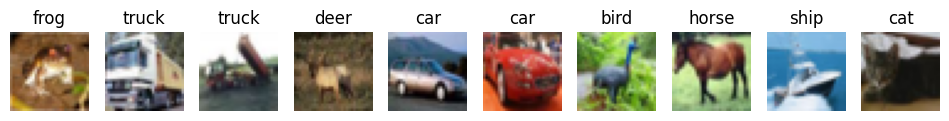

In [8]:
fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    axes[i].imshow(image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()


In [9]:
class ConvNeuralNet(nn.Module):
    def __init__(self, in_channels = 3, num_classes = 10):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, 64, 3)
        self.conv2 = nn.Conv2d(64, 128, 3)

        self.pool = nn.MaxPool2d(2, stride=2)

        self.gap = nn.AdaptiveAvgPool2d(1) # to work with variable image sizes

        # self.fc1 = nn.Linear(128 * 6 * 6, 120)
        self.fc1 = nn.Linear(128, 120) # because output of self.gap is [batch, 128, 1, 1]
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.gap(x) # to work with variable image sizes
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # x = F.softmax(self.fc3(x), dim=1)
        # print(x)
        return x

net = ConvNeuralNet()
net.to(device)
PATH = './cifar_net_variable_image_sizes.pth'

In [10]:
if os.path.isfile(PATH):
    net.load_state_dict(torch.load(PATH, weights_only=True))
    print("existing model loaded")
    
    # for i, data in enumerate(train_loader):
    #     inputs, labels = data[0].to(device), data[1].to(device)
    #     print(inputs.shape)
else:
    print("no existing model found. Initiating training\n")
    loss_function = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    epochs = 10
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(train_loader):

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            
            if i == 0:
                print(labels)
                print(outputs)
            
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')
    torch.save(net.state_dict(), PATH)

existing model loaded


In [11]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    # denormalized_image= image / 2 + 0.5
    ax1.imshow(image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
    plt.show()

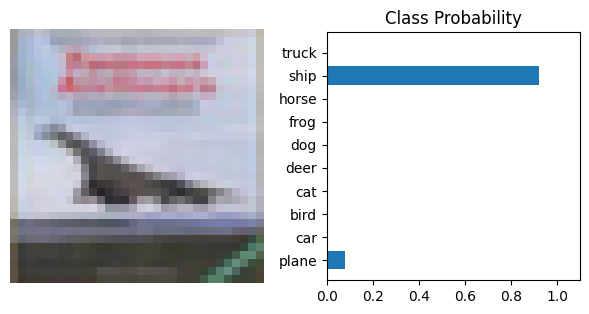

In [12]:
images, _ = next(iter(test_loader))

image = images[3]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)
    probabilities = torch.softmax(log_probabilities, dim=1)

probabilities = probabilities.squeeze().cpu()
view_classification(image, probabilities)

In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        # print(labels)

        outputs = net(images)
        # print(outputs)

        _, predicted = torch.max(outputs.data, 1)
        # print(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print(correct)
        # print()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 63 %


In [14]:
# Freeze all the parameters in the network
net.eval()
for param in net.parameters():
    param.requires_grad = False

In [15]:
'''
With a higher res image
'''

pilimage = Image.open('boat.jpg')
pilimage.show()
# tensorpilimage = transform(pilimage)
# print(tensorpilimage.shape)
# showImage(tensorpilimage.permute(1, 2, 0))


Now going to next image


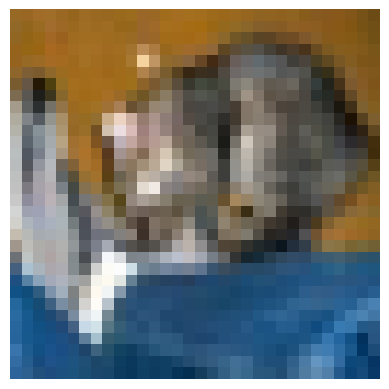

cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
frog

Optimized image labled as frog:


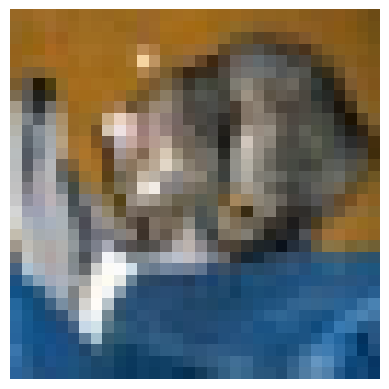


Noise between original and optimized:


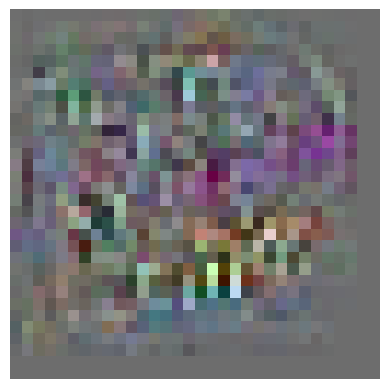

95.22915539113694


Now going to next image


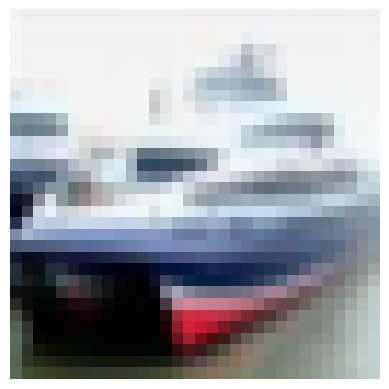

ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
b

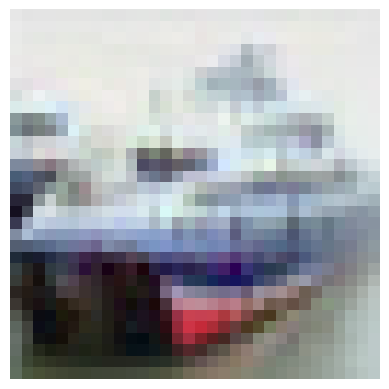


Noise between original and optimized:


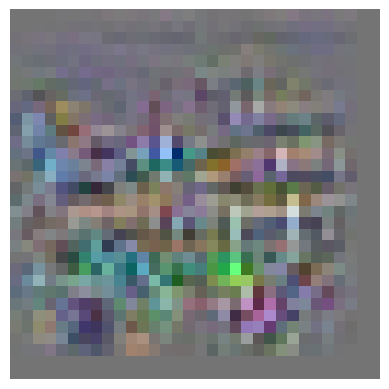

77.35652586454131


Now going to next image


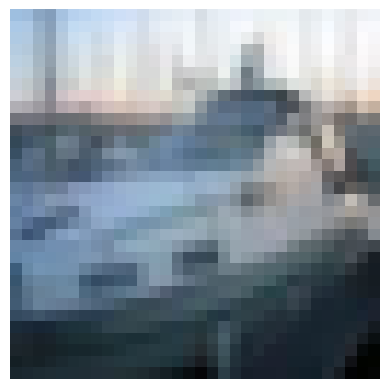

ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
frog

Optimized image labled as frog:


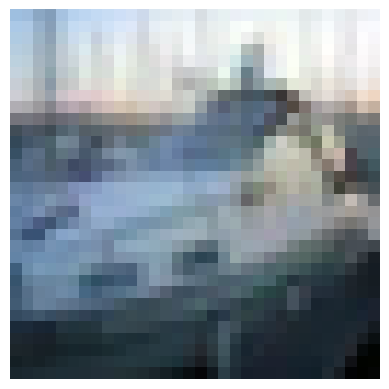


Noise between original and optimized:


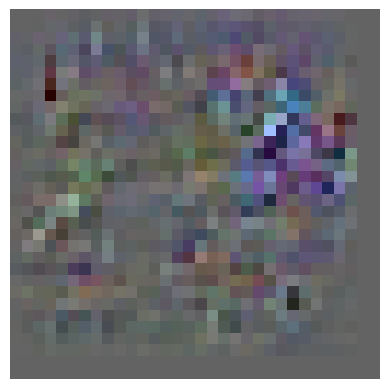

84.57688791866389


Now going to next image


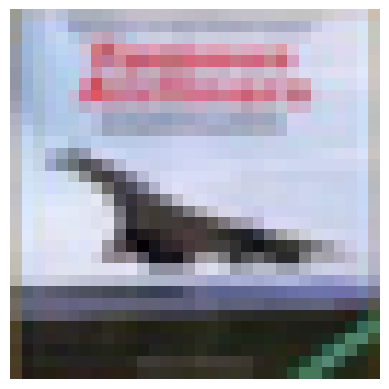

ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
ship
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
plane
frog

Optimized image labled as frog:


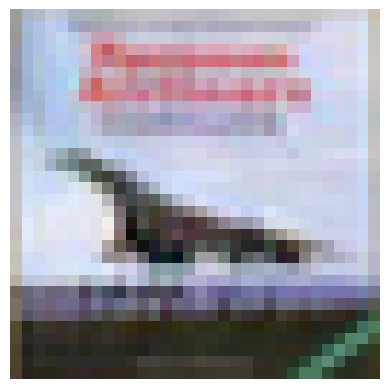


Noise between original and optimized:


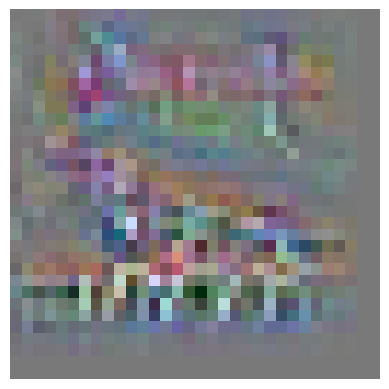

81.55239701079151


Now going to next image


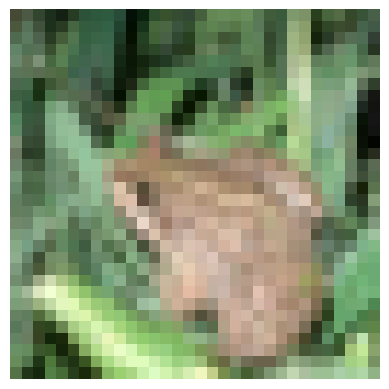


Now going to next image


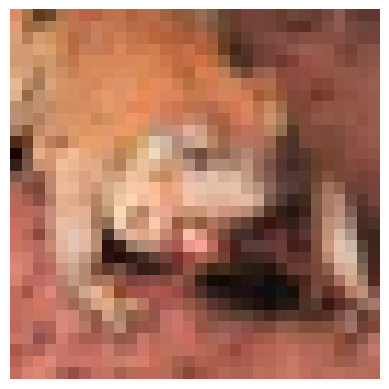


Now going to next image


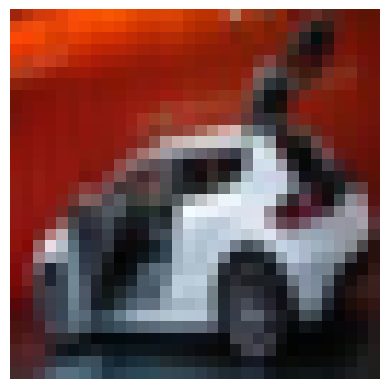

car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
car
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
frog

Optimized image labled as frog:


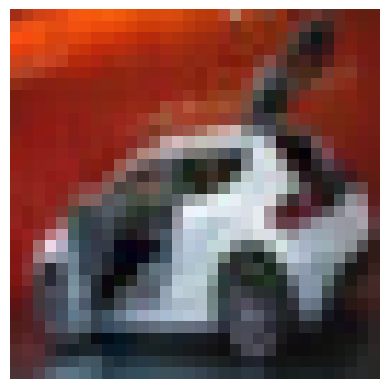


Noise between original and optimized:


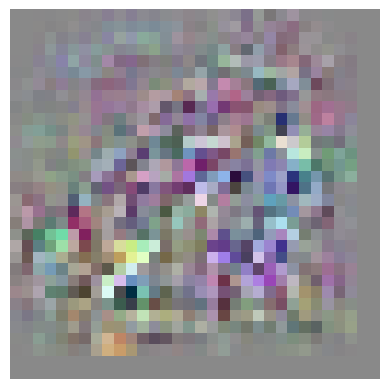

81.30048162477145


Now going to next image


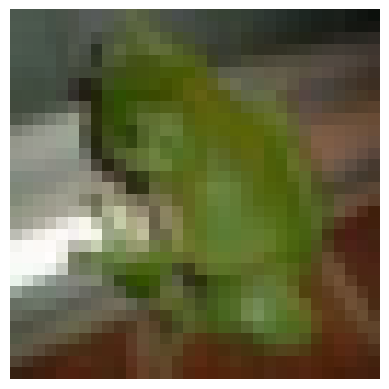


Now going to next image


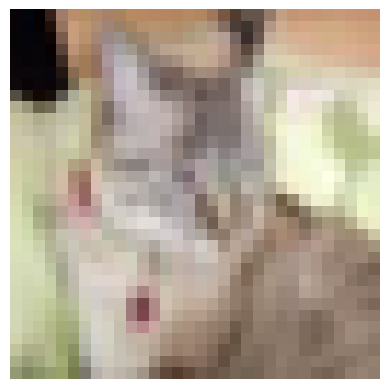

deer
deer
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
cat
frog

Optimized image labled as frog:


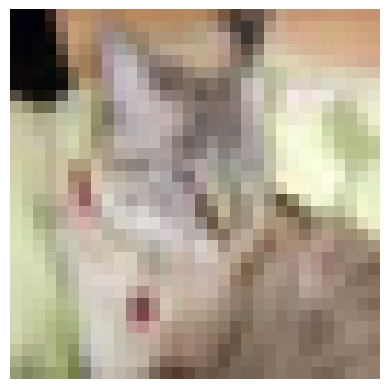


Noise between original and optimized:


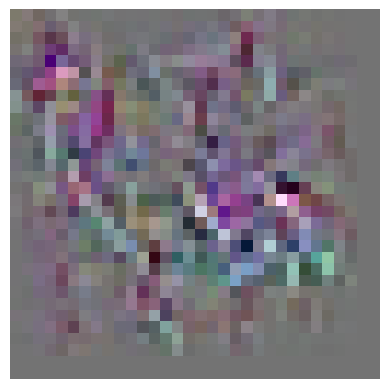

89.25558122286652


Now going to next image


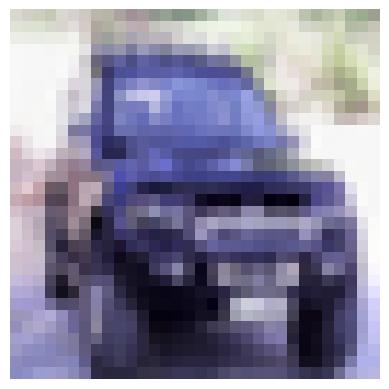

car
car
car
car
car
car
car
car
car
car
car
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
frog

Optimized image labled as frog:


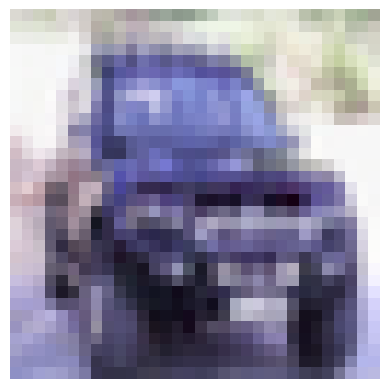


Noise between original and optimized:


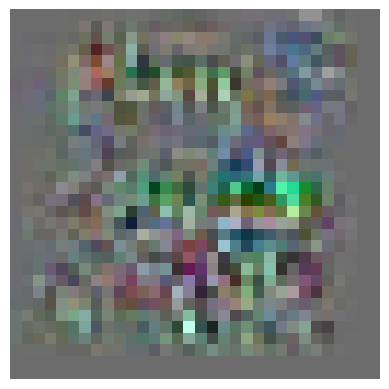

87.14624675457365


Now going to next image


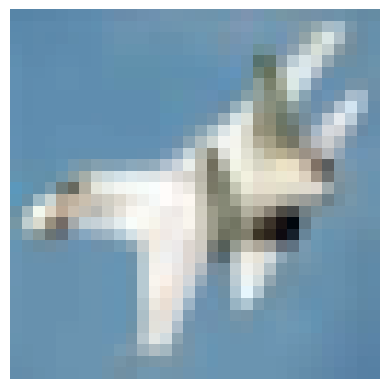

deer
deer
deer
deer
deer
deer
deer
deer
deer
deer
deer
deer
deer
deer
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
dog
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bird
bi

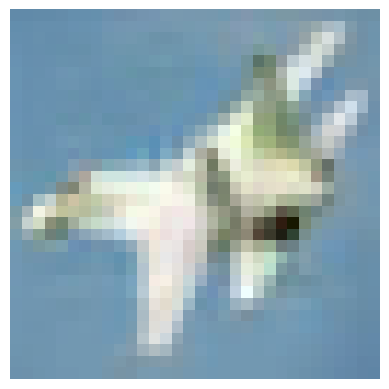


Noise between original and optimized:


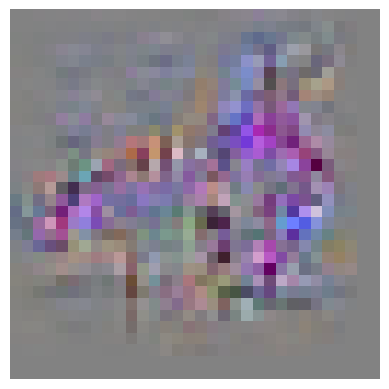

84.00270267481861


Now going to next image


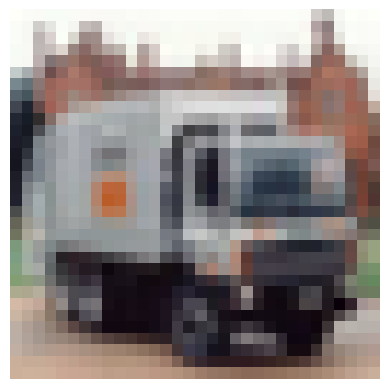

truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
truck
dog
frog

Optimized image labled as frog:


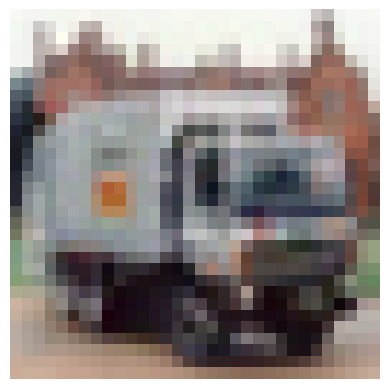


Noise between original and optimized:


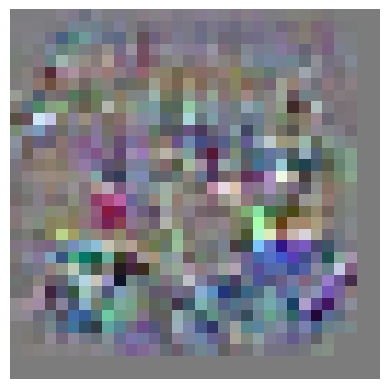

81.80686735847907


Now going to next image


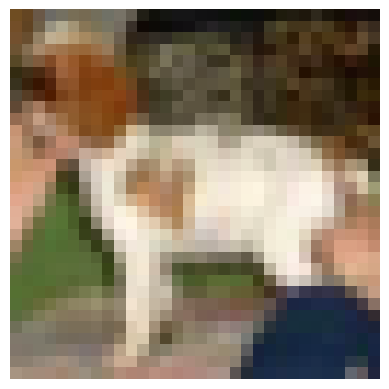

deer
deer
deer
deer
deer
deer
deer
deer
deer
frog

Optimized image labled as frog:


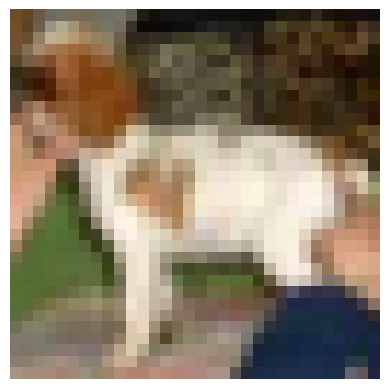


Noise between original and optimized:


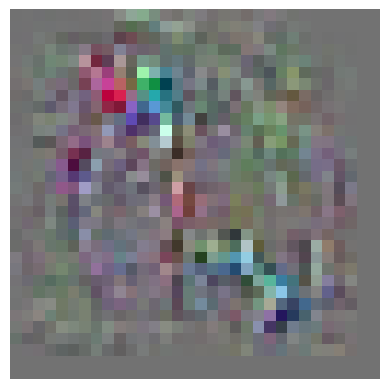

104.6570394740462

Average PSNR over 10 samples is 86.68838852946891
shape of stacked noise: torch.Size([10, 3, 32, 32])


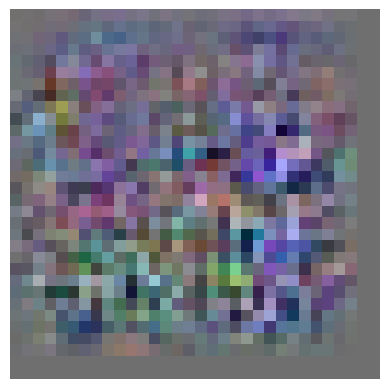

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x1 and 128x120)

In [ ]:

label = torch.tensor([6]).to(device)
x = torch.tensor([0, 0, 1, 0, 0, 0, 0, 0, 1, 0]).float().to(device)

totalPSNR = 0.0
amountSamples = 0

noiseList = []

for im in test_loader.dataset:
    print()
    print("Now going to next image")
    original_img = im[0]
    showImage(original_img.permute(1, 2, 0))
    # original_img = tensorpilimage
    original_img = original_img.to(device)

    img = original_img.to(device)
    img = img.unsqueeze(0)
    img = img.requires_grad_(True)

    # loss_function = nn.NLLLoss()
    loss_function = nn.CrossEntropyLoss()
    loss_function2 = nn.MSELoss()
    sigmoid = nn.Sigmoid()

    experimentOptimizer = torch.optim.SGD([img], lr=0.001, momentum=0.3)

    predictedClass = -1

    # for _ in range(500):
    if im[1] != 6:
        while predictedClass != label.item():
        # while probabilities2[2] != max(probabilities2) and probabilities2[2] != 0:
            experimentOptimizer.zero_grad()

            output = net(img)

            # probabilities = torch.softmax(output, dim=1).squeeze().cpu()

            probabilities = torch.softmax(output, dim=1).squeeze()
            # probabilities2 = probabilities
            predictionTensor = torch.argmax(probabilities)
            predictionInt = predictionTensor.item()
            predictedClass = predictionInt
            print(classes[predictionInt])

            # celoss = loss_function(probabilities, x)
            celoss = loss_function(output, label)
            # lossimg = original_img.unsqueeze(0) - img
            # maxval = torch.max(lossimg)
            l1loss = loss_function2(original_img.unsqueeze(0), sigmoid(img))
            loss = celoss + l1loss

            celoss.backward()
            experimentOptimizer.step()

        print()
        print("Optimized image labled as frog:")
        showImage(img.squeeze().detach().cpu().permute(1, 2, 0))

        noise = im[0] - img.squeeze().detach().cpu()

        print()
        print("Noise between original and optimized:")
        showImage(noise.permute(1, 2, 0))

        noiseList.append(noise)

        numpy_image = im[0].numpy()
        # print("numpy image:")
        # showImage(np.transpose(numpy_image, (1, 2, 0)))
        cv_image = np.transpose(numpy_image, (1, 2, 0))
        cv_image = cv.cvtColor(cv_image, cv.COLOR_BGR2RGB)

        numpy_image2 = img.squeeze().detach().cpu().numpy()
        # print("numpy optimized image image:")
        # showImage(np.transpose(numpy_image2, (1, 2, 0)))
        cv_image2 = np.transpose(numpy_image2, (1, 2, 0))
        cv_image2 = cv.cvtColor(cv_image2, cv.COLOR_BGR2RGB)
        
        val = PSNR(cv_image, cv_image2)
        print(val)
        print()

        totalPSNR += val
        amountSamples += 1

    if amountSamples == 10:
        break

print(f"Average PSNR over {amountSamples} samples is {totalPSNR / amountSamples}")

stacked_noise = torch.stack(noiseList, dim=0)
print("shape of stacked noise:", stacked_noise.shape)
average_noise = torch.mean(stacked_noise, dim=0)
showImage(average_noise.permute(1, 2, 0))

amountSamples2 = 0

for im in test_loader.dataset:
    if im[1] != 6:
        amountSamples2 += 1
        testimage = im[0] + average_noise
        output2 = net(testimage.unsqueeze(0).to(device))
        probabilities = torch.softmax(output2, dim=1).squeeze()
        predictionTensor = torch.argmax(probabilities)
        predictionInt = predictionTensor.item()
        predictedClass = predictionInt

        print()
        print("Image with average noise added:")
        showImage(testimage.permute(1, 2, 0))
        print("Predicted class:", classes[predictionInt])

    if amountSamples2 == 10:
        break

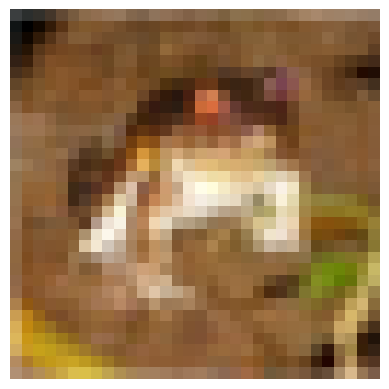

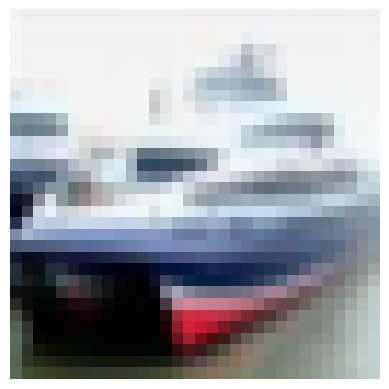

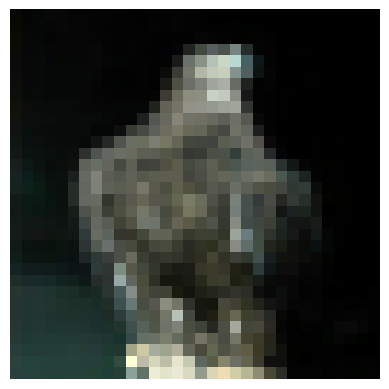

tensor([[[ 0.9059,  0.8980,  0.8980,  ...,  0.9138,  0.9137,  0.9098],
         [ 0.9137,  0.9098,  0.9136,  ...,  0.9255,  0.9255,  0.9216],
         [ 0.9019,  0.9021,  0.9099,  ...,  0.9216,  0.9216,  0.9176],
         ...,
         [ 0.2432,  0.0862, -0.0118,  ...,  0.6627,  0.7137,  0.7373],
         [ 0.2157,  0.0902,  0.0510,  ...,  0.6784,  0.7216,  0.7294],
         [ 0.2275,  0.1490,  0.1333,  ...,  0.6549,  0.7020,  0.7216]],

        [[ 0.9059,  0.8980,  0.8940,  ...,  0.9137,  0.9137,  0.9098],
         [ 0.9137,  0.9098,  0.9058,  ...,  0.9255,  0.9255,  0.9216],
         [ 0.9059,  0.9021,  0.9022,  ...,  0.9216,  0.9216,  0.9176],
         ...,
         [ 0.2392,  0.0509, -0.0589,  ...,  0.7216,  0.7725,  0.7922],
         [ 0.2157,  0.0627,  0.0118,  ...,  0.7373,  0.7804,  0.7882],
         [ 0.2392,  0.1373,  0.1020,  ...,  0.7137,  0.7569,  0.7765]],

        [[ 0.9137,  0.8980,  0.8941,  ...,  0.9136,  0.9137,  0.9098],
         [ 0.9216,  0.9098,  0.9098,  ...,  0

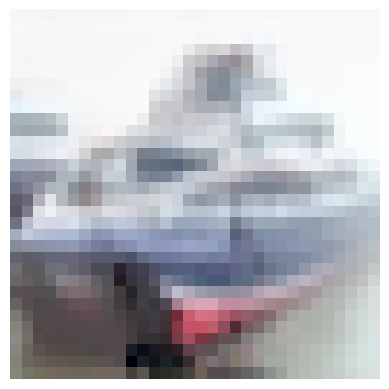

following images has been converted to a frog:
PSNR value: 52.25152736320198


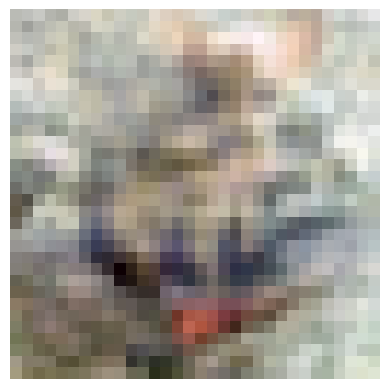

0.06


In [17]:
image = test_loader.dataset[1][0]

otherTestImage = train_loader.dataset[0][0]
showImage(otherTestImage.permute(1, 2, 0))
# image = tensorpilimage
# denormalized_image= image / 2 + 0.5

showImage(image.permute(1, 2, 0))
showImage(img.squeeze().detach().permute(1, 2, 0).cpu())

diff = image - img.squeeze().detach().cpu()
# diff = torch.abs(diff)
# diff[diff <= 0.0004] = 1
# diff *= 10000
print(diff)

showImage(diff.permute(1, 2, 0))


# dreamsimModel, preprocess = dreamsim(pretrained=True, cache_dir="/home/jv/.cache")

# pilTransform = transforms.ToPILImage()

# pilimage1 = pilTransform(image)
# pilimage2 = pilTransform(otherTestImage)

# asldkf = pilTransform(image)
# asldkf.show()

# dreamsimImage1 = preprocess(Image.open("cifarboat.jpg"))
# dreamsimImage2 = preprocess(Image.open("cifarfrog.jpg"))

# dreamsimImage1 = dreamsimImage1.to(device)
# dreamsimImage2 = dreamsimImage2.to(device)

# distance = dreamsimModel(dreamsimImage1, dreamsimImage1)
# print()
# print("DISTANCE:", distance)
# print()

# original_images = []
# images2 = []

count = 0

for im in test_loader.dataset:
    # original_image = im[0]
    # original_image = original_image.to(device)
    # original_images.append(original_image)

    # image2 = im[0].to(device)
    # image2 = image2.unsqueeze(0)
    # image2 = image2.requires_grad_(True)
    # images2.append(image2)

    label2 = im[1]
    new = im[0] + diff
    output = net(new.unsqueeze(0).to(device))

    # probabilities = torch.softmax(output, dim=1).squeeze().cpu()
    # print(classes[torch.argmax(probabilities).item()])
    # print(output)
    # print(label)

    probabilities = torch.softmax(output, dim=1).squeeze()
    # probabilities2 = probabilities
    # print(probabilities)
    predictionTensor = torch.argmax(probabilities)
    predictionInt = predictionTensor.item()
    if predictionInt == 6:
        count += 1
        if label2 != 6:
            print("following images has been converted to a frog:")
            print("PSNR value:", PSNR(cv.cvtColor(np.transpose(im[0].numpy(), (1, 2, 0)), cv.COLOR_BGR2RGB), cv.cvtColor(np.transpose(new.numpy(), (1, 2, 0)), cv.COLOR_BGR2RGB)))
            showImage(new.permute(1, 2, 0))
        # if label2.
    # predictedClass = predictionInt
    # print(classes[predictionInt])

print((count/len(test_loader.dataset))*100)

# showImage(test_loader.dataset[6][0].permute(1, 2, 0))
# showImage(new.permute(1, 2, 0))



# new_img = test_loader.dataset[126][0]
# new_img += diff

# output = net(new_img.to(device).unsqueeze(0))

# probabilities = torch.softmax(output, dim=1)
# predictionTensor = torch.argmax(probabilities)
# predictionInt = predictionTensor.item()
# predictedClass = predictionInt
# print(classes[predictionInt])

# reconstructed_img = torch.stack(iterable_of_tensors, dim = 0)

# mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(3, 1, 1)
# std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(3, 1, 1)
# reconstructed_img2 = reconstructed_img / 2 + 0.5  # Reverse normalization
# output = net(reconstructed_img.unsqueeze(0))
# print(reconstructed_img)


# Clip to valid range [0, 1] (for visualization)
# reconstructed_img2 = torch.clamp(reconstructed_img2, 0, 1)

# probabilities = torch.softmax(output, dim=1).squeeze().cpu()
# print(probabilities.sum())
# print(classes[torch.argmax(probabilities).item()])

# # Convert to NumPy and permute dimensions for matplotlib (H × W × C)
# img_np = reconstructed_img2.detach().cpu().numpy().transpose(1, 2, 0)

# # Visualize
# plt.imshow(img)
# plt.axis('off')  # Hide axes
# plt.show()

# # Visualize
# plt.imshow(img_np)
# plt.axis('off')  # Hide axes
# plt.show()